In [3]:
import numpy as np

import matplotlib as mpl

import matplotlib.pyplot as plt
plt.ion()
import math
# for the symbolic manipulation of jacobian
import sympy as sp
from sympy import init_printing
init_printing() # doctest: +SKIP
# from sympy import symbols
from sympy import sin, cos, asin, acos, pi, atan2, sqrt, N
from sympy.utilities.lambdify import lambdify
from sympy import Matrix

from scipy.optimize import minimize
from scipy.optimize import fsolve

def T(theta, x, y):
    """
    Function to return an arbitrary transformation matrix 
    This is for sympy symbolic calculation
    """
    return Matrix([[cos(theta), -sin(theta), x], 
                   [sin(theta), cos(theta), y],
                   [0, 0, 1]])

def sym_to_np(T):
    return np.array(T).astype(np.float64)

(
 theta1, 
 theta2,
 theta3,
 theta4,
 theta5,
 x,
a1,
a2,
psi1,
psi2,
    
 y) = sp.symbols("""
                    theta1, 
                    theta2, 
                    theta3,
                    theta4,
                    theta5,
                    x,
                    a1,
                    a2,
                    psi1,
                    psi2
                    y""" , real = True)

(l1, 
 l2, 
 L,
 M,
 w) = sp.symbols("""   l1, 
                    l2,
                    M,
                    L,
                    w""" , real = True, positive=True)
a1 = sp.sqrt(l1**2 + w**2 - 2*l1*w*sp.cos(theta2))
a2 = sp.sqrt(l1**2 + w**2 - 2*l1*w*sp.cos(sp.pi-theta1))
L = sp.sqrt((w + l1*sp.cos(theta1) - l1*sp.cos(theta2))**2 + (l1*sp.sin(theta1) - l1*sp.sin(theta2))**2)
psi1 = sp.asin(sp.sin(sp.pi-theta1)*w/a2)
psi2 = sp.cos((a2**2 + L**2 - l1**2)/(2*a2*L))
theta4 = psi1 + psi2
theta3 = sp.pi - theta4
theta5 = sp.acos(L/(2*l2))


T_01 = T(theta1, w/2, 0)
T_12 = T(theta3, l1, 0)
x2y2 = sp.Matrix([[L/2],[sp.sqrt(l2**2-(L/2)**2)], [1]])
FK_parallel = T_01 * T_01 * x2y2
FK_parallel = FK_parallel[:2,:]
FK_parallel.simplify()
xy_check = N(FK_parallel.subs([(theta1, math.pi/2),(theta2, math.pi/2), (l1,1), (l2,1), (w,1)]))
print("Forward Kinematics")
print(FK_parallel)
print("\nPlug in pi/2 to check x is 0:")
print("x val: " + str(xy_check[0,0]))


J_parallel = FK_parallel.jacobian([theta1, theta2])
J_parallel.simplify()



q1 = np.linspace(-np.pi, np.pi, 100)
q2 = np.linspace(-np.pi, np.pi, 100)

proprioception = np.zeros((q1.shape[0], q2.shape[0]))
force_production = np.zeros((q1.shape[0], q2.shape[0]))
workspace = np.zeros((q1.shape[0], q2.shape[0], 2))


J_parallel_fast = lambdify((theta1, theta2, l1, l2, w), J_parallel)

FK_parallel_fast = lambdify((theta1, theta2, l1, l2, w), FK_parallel)



for j, q1_ang in enumerate(q1):
    for k, q2_ang in enumerate(q2):

        
        workspace[j,k, :] = FK_parallel_fast(q1_ang, q2_ang, 0.2, 0.1, 0.1).T
        
        J_current = J_parallel_fast(q1_ang, q2_ang, 0.2, 0.1, 0.1)

        u, s, v = np.linalg.svd(J_current)
        
        proprioception[j, k] = s[1]**2 ## Since the svd returns singular values in decreasing magnitude order, s[1] is the smallest of the two 
        force_production[j, k] = 1/s[0]**2
        


Forward Kinematics
Matrix([[w*cos(theta1)/2 + w/2 + sqrt(-2*l1**2*cos(theta1 - theta2) + 2*l1**2 + 2*l1*w*cos(theta1) - 2*l1*w*cos(theta2) + w**2)*cos(2*theta1)/2 - sqrt(2*l1**2*cos(theta1 - theta2) - 2*l1**2 - 2*l1*w*cos(theta1) + 2*l1*w*cos(theta2) + 4*l2**2 - w**2)*sin(2*theta1)/2], [w*sin(theta1)/2 + sqrt(-2*l1**2*cos(theta1 - theta2) + 2*l1**2 + 2*l1*w*cos(theta1) - 2*l1*w*cos(theta2) + w**2)*sin(2*theta1)/2 + sqrt(2*l1**2*cos(theta1 - theta2) - 2*l1**2 - 2*l1*w*cos(theta1) + 2*l1*w*cos(theta2) + 4*l2**2 - w**2)*cos(2*theta1)/2]])

Plug in pi/2 to check x is 0:
x val: -1.06057523872491e-16


<string>:2: RuntimeWarning: invalid value encountered in sqrt
<string>:2: RuntimeWarning: invalid value encountered in sqrt


I know these plots below are wrong. I have spent hours trying to figure out this "RuntimeWarning: invalid value encountered in sqrt" issue I am getting. I assume my FK is wrong, however I've spent hours on it and can't figure out where I've gone wrong. I know I'm getting a negative number somewhere.

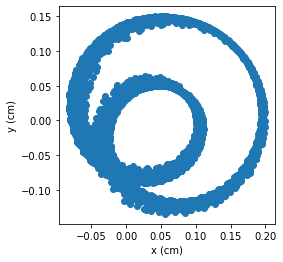

In [2]:
plt.clf()
plt.plot(np.ravel(workspace[:,:,0]), np.ravel(workspace[:,:,1]), 'o')
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.gca().set_aspect('equal')

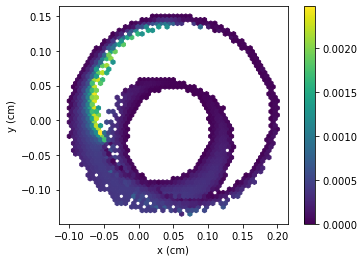

In [42]:
plt.clf()
plt.hexbin(np.ravel(workspace[:,:,0]), np.ravel(workspace[:,:,1]), C = np.ravel(proprioception), gridsize = 50)
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.gca().set_aspect('equal')
plt.colorbar()

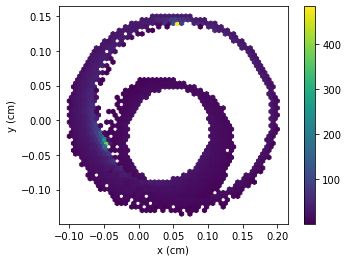

In [43]:
plt.clf()
plt.hexbin(np.ravel(workspace[:,:,0]), np.ravel(workspace[:,:,1]), C = np.ravel(force_production), gridsize = 50)
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.gca().set_aspect('equal')
plt.colorbar()

Workspace Theta

![Workspace - Theta](MAE207Workspace.png)

![title](MAE207WorkspaceXY.png)

![title](paperwork.jpg)